   age   workclass      education  education-num       marital-status  \
0   25     Private           11th              7        Never-married   
1   38     Private        HS-grad              9   Married-civ-spouse   
2   28   Local-gov     Assoc-acdm             12   Married-civ-spouse   
3   44     Private   Some-college             10   Married-civ-spouse   
4   18         NaN   Some-college             10        Never-married   

           occupation relationship    race      sex  capital-gain  \
0   Machine-op-inspct    Own-child   Black     Male             0   
1     Farming-fishing      Husband   White     Male             0   
2     Protective-serv      Husband   White     Male             0   
3   Machine-op-inspct      Husband   Black     Male          7688   
4                 NaN    Own-child   White   Female             0   

   capital-loss  hours-per-week  native-country   class  
0             0              40   United-States   <=50K  
1             0              5

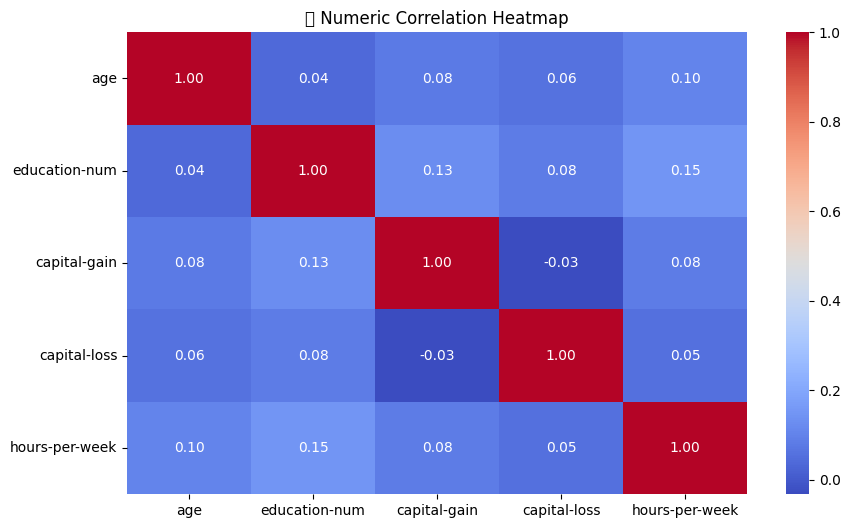


✅ 다중공선성 높은 변수 제거: []

🚀 RandomForest 모델 학습 중...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ RandomForest 최적 파라미터:
 {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': None}
✅ RandomForest 정확도: 0.8578
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6803
           1       0.77      0.61      0.68      2242

    accuracy                           0.86      9045
   macro avg       0.82      0.77      0.79      9045
weighted avg       0.85      0.86      0.85      9045


🚀 XGBoost 모델 학습 중...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ XGBoost 최적 파라미터:
 {'clf__subsample': 1.0, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.2}
✅ XGBoost 정확도: 0.8661
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      6803
           1       0.77      0.65      0.71      2242

    accuracy  

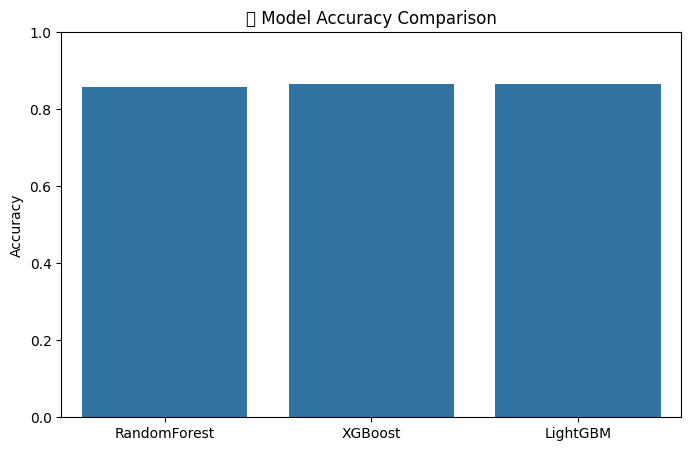

In [1]:
# ===============================
# 💼 성인 연봉 데이터 통합 분석 파이프라인
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ===============================
# 1️⃣ 데이터 불러오기
# ===============================
df = pd.read_csv("./data/salary2.csv")  # 파일명 예시
print(df.head())

# ===============================
# 2️⃣ 결측치 처리
# ===============================
print("\n✅ 결측치 개수:\n", df.isnull().sum())

# 단순 대체 (수치형: 평균, 범주형: 최빈값)
df = df.dropna()

# ===============================
# 3️⃣ 이상치 처리 (Z-score 기준)
# ===============================
num_cols = df.select_dtypes(include=np.number).columns

# z_scores = np.abs(stats.zscore(df[num_cols]))
# df = df[(z_scores < 3).all(axis=1)]  # |Z| < 3 인 것만 남김
# print(f"\n✅ 이상치 제거 후 데이터 크기: {df.shape}")

# ===============================
# 4️⃣ 상관분석 (수치형 변수 중심)
# ===============================
corr = df[num_cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("📊 Numeric Correlation Heatmap")
plt.show()

# 강한 상관관계 변수 제거 (예: 0.9 이상)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df = df.drop(columns=to_drop)
print(f"\n✅ 다중공선성 높은 변수 제거: {to_drop}")

# ===============================
# 5️⃣ 독립변수 / 종속변수 분리
# ===============================
X = df.drop("class", axis=1)
y = df["class"].map({" >50K":1, " <=50K":0})  # 이진 변환

# ===============================
# 6️⃣ 학습/검증 데이터 분리
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================
# 7️⃣ 전처리 파이프라인
# ===============================
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

# ===============================
# 8️⃣ 모델 정의
# ===============================
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# ===============================
# 9️⃣ RandomizedSearchCV 파라미터 설정
# ===============================
param_grids = {
    'RandomForest': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 5, 10, 20],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7, 9],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__subsample': [0.6, 0.8, 1.0]
    },
    'LightGBM': {
        'clf__n_estimators': [100, 200, 300],
        'clf__num_leaves': [15, 31, 63],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__subsample': [0.6, 0.8, 1.0]
    }
}

# ===============================
# 🔟 모델 학습 및 평가
# ===============================
results = {}

for name, model in models.items():
    print(f"\n🚀 {name} 모델 학습 중...")
    
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('clf', model)
    ])
    
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_grids[name],
        n_iter=10,
        cv=3,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"\n✅ {name} 최적 파라미터:\n", search.best_params_)
    print(f"✅ {name} 정확도: {acc:.4f}")
    print(classification_report(y_test, y_pred))

# ===============================
# 🔚 모델 성능 비교 시각화
# ===============================
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("🔍 Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

In [4]:
# !pip install flaml

In [3]:
# (필요 시) !pip install flaml
from flaml import AutoML

# ===============================
# 🔟-추가) FLAML AutoML 베이스라인
# ===============================
print("\n🚀 FLAML AutoML 학습 중...")

automl = AutoML()
automl.fit(
    X_train, y_train,
    task="classification",
    time_budget=60,                 # ⏱️ 총 탐색 시간(초) - 상황에 맞게 조절
    metric="accuracy",               # 평가지표(불균형이면 'f1'/'roc_auc' 권장)
    eval_method="cv",                # 교차검증
    n_splits=3,
    estimator_list=["lgbm", "xgboost", "rf", "extra_tree"],  # 설치된 환경에 맞춰 사용
    verbose=1
)

print("\n✅ FLAML Best Estimator:", automl.best_estimator)
print("✅ FLAML Best Config:", automl.best_config)
print("✅ FLAML Best Loss:", automl.best_loss)

y_pred_flaml = automl.predict(X_test)
acc_flaml = accuracy_score(y_test, y_pred_flaml)
print(f"✅ FLAML 정확도: {acc_flaml:.4f}")
print(classification_report(y_test, y_pred_flaml))

# 기존 결과 dict에 추가
results['FLAML'] = acc_flaml


🚀 FLAML AutoML 학습 중...

✅ FLAML Best Estimator: lgbm
✅ FLAML Best Config: {'n_estimators': 585, 'num_leaves': 17, 'min_child_samples': 2, 'learning_rate': np.float64(0.016011760634445815), 'log_max_bin': 7, 'colsample_bytree': np.float64(0.6315891698974688), 'reg_alpha': np.float64(0.004577823970660193), 'reg_lambda': np.float64(0.11730292400384558)}
✅ FLAML Best Loss: 0.1301655748127263
✅ FLAML 정확도: 0.8657
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      6803
           1       0.77      0.65      0.71      2242

    accuracy                           0.87      9045
   macro avg       0.83      0.79      0.81      9045
weighted avg       0.86      0.87      0.86      9045

